# Mercari Price Suggestion Challenge
* url: https://www.kaggle.com/c/mercari-price-suggestion-challenge

### import module

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
from collections import Counter, defaultdict

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import helper_function as helper

### data exploration

In [2]:
#train = pd.read_csv('sample_data/train.tsv', sep='\t')
#test = pd.read_csv('sample_data/test.tsv', sep='\t')
submission = pd.read_csv('sample_data/sample_submission.csv', sep=',')

In [3]:
train = pd.read_csv('data/train.tsv', sep='\t')
#test = pd.read_csv('data/test.tsv', sep='\t')

In [4]:
train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [5]:
submission.head(3)

,test_id,price
0,0,26.738
1,1,26.738
2,2,26.738


In [6]:
train.shape

(1482535, 8)

In [7]:
train.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [8]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

### Price
* log_price = <b>Log2( price+1 )</b>
* log_price_slot = ceil( <b>Log2( price+1 )</b> )

In [9]:
log_price = list(helper.log(train.price))
log_price_slot = list(helper.log(train.price, slot=True))
train['log_price_slot'] = log_price_slot
train['log_price'] = log_price

In [10]:
train['log_price_slot'].value_counts()

4     515105
5     490311
6     223163
3     132218
7      74964
8      21247
2      18703
9       4924
10       881
0        874
11       145
Name: log_price_slot, dtype: int64

### Pricing and Item Condition ID

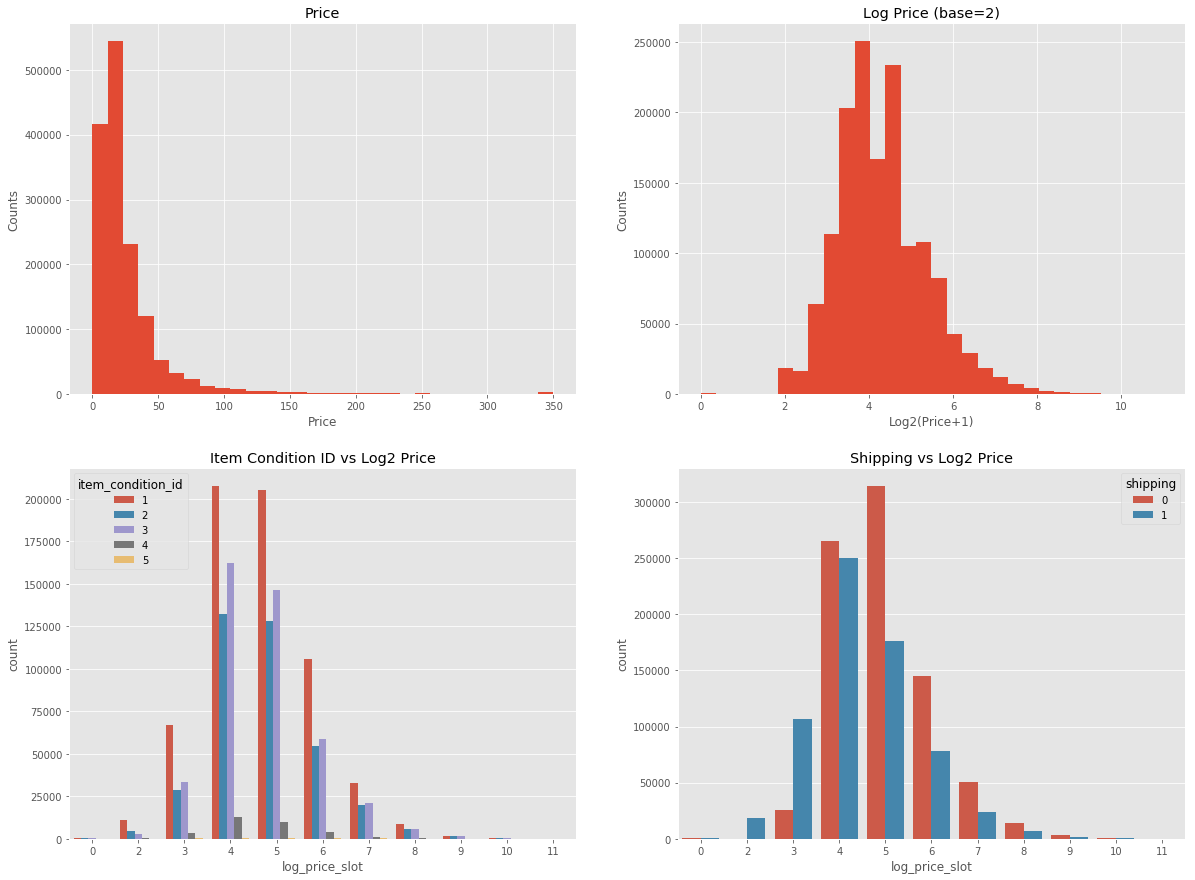

In [11]:
f,ax=plt.subplots(2,2,figsize=(20,15))

ax[0,0].hist(list(helper.price_scale(train.price, n=350)), bins = 30,label = 'price')
ax[0,0].set_title("Price")
ax[0,0].set_xlabel("Price")
ax[0,0].set_ylabel("Counts")

ax[0,1].hist('log_price', bins = 30,label='price', data=train)
ax[0,1].set_title("Log Price (base=2)")
ax[0,1].set_xlabel("Log2(Price+1)")
ax[0,1].set_ylabel("Counts")

sns.countplot('log_price_slot', hue='item_condition_id', data=train, ax=ax[1,0])
ax[1,0].set_title('Item Condition ID vs Log2 Price')
sns.countplot('log_price_slot', hue='shipping',data=train,ax=ax[1,1])
ax[1,1].set_title('Shipping vs Log2 Price')
plt.show()

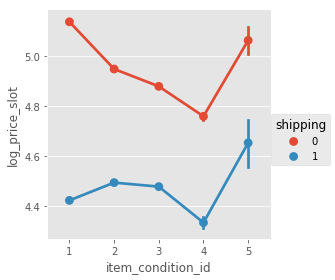

In [12]:
# sns.factorplot(log_price_slot, 'item_condition_id' ,hue='shipping',col='', data=train)
sns.factorplot('item_condition_id', 'log_price_slot' ,hue='shipping', data=train)
plt.show()

In [13]:
print("Item Condition ID vs Shipping")
pd.crosstab(train.shipping,train.item_condition_id,margins=False).style.background_gradient(cmap='summer_r')

Item Condition ID vs Shipping


item_condition_id,1,2,3,4,5
shipping,,,,,
0,280107,232509,283691,21603,1525
1,360442,142970,148470,10359,859


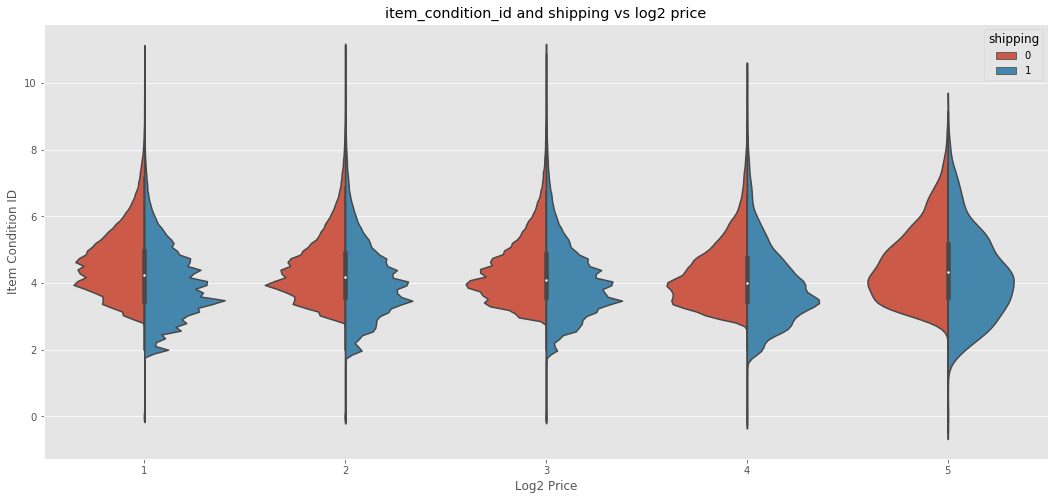

In [14]:
f,ax=plt.subplots(figsize=(18,8))
sns.violinplot(train.item_condition_id, log_price, hue=train.shipping, split=True)
ax.set_title('item_condition_id and shipping vs log2 price')
ax.set_xlabel("Log2 Price")
ax.set_ylabel("Item Condition ID")
plt.show()

### Brand Name

In [15]:
brand_num = len(train.brand_name.value_counts())
print("There are {} brand in this dataset".format(brand_num))

train['brand'] = train.brand_name.apply(helper.brand_None)
brand_null_num = (train['brand'] == "None").sum()
print("There are {} null in Brand Names".format(brand_null_num))

train.brand_name.value_counts()[:5]

There are 4809 brand in this dataset
There are 632682 null in Brand Names


PINK                 54088
Nike                 54043
Victoria's Secret    48036
LuLaRoe              31024
Apple                17322
Name: brand_name, dtype: int64

<br>
#### brand vs price
* there are many outliers
    * use <b>median price</b> rather than average price on each brand
<br>

In [16]:
brand_price = defaultdict(list)
for brand, price in zip(train.brand, train.price):
    brand_price[brand].append(price)

fig = helper.brand_box_plot(brand_price, show=50)
iplot(fig)

In [17]:
brand_price_median_dict = defaultdict(int)
for brand, price in brand_price.items():
    brand_price_median_dict[brand] = helper.median(price)
    
brand_price_median = helper.brand_dict2Series(brand_price_median_dict)

In [18]:
fig = helper.brand_median_price_plot(brand_price_median, top_n=50)
iplot(fig)

### Category Name

In [19]:
print("There are {} items do not get category name".format( train.category_name.isnull().sum() ))
train.category_name.value_counts()[:5]

There are 6327 items do not get category name


Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Name: category_name, dtype: int64

In [20]:
def count_len(s, sep='/'):
    try: # if s is not None
        return len(s.split(sep))
    except: # if s is None
        return 0
    

Counter([count_len(i) for i in train.category_name])

Counter({0: 6327, 3: 1471819, 4: 1330, 5: 3059})

In [21]:
[count_len(i) for i in train.category_name[:5]]

[3, 3, 3, 3, 3]

<br><br><br><br>
## Get Features
* `train_id` or `test_id` - the id of the listing <br>
* `name` - the title of the listing. 
Note that we have cleaned the data to remove text that look like prices (e.g. \$20) to avoid leakage. These removed prices are represented as [rm] <br>
* `item_condition_id` - the condition of the items provided by the seller <br>
* `category_name` - category of the listing <br>
* `brand_name` <br>
* `price` - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict. <br>
* `shipping` - 1 if shipping fee is paid by seller and 0 by buyer <br>
* `item_description` - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. \$20) to avoid leakage. These removed prices are represented as [rm]

In [22]:
train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price_slot,log_price,brand
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,4,3.459432,None
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,6,5.727920,Razer
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,4,3.459432,Target


In [23]:
def get_brand_median_price(brand, price):
    """get median price on each brand
    input:
        brand: list
        price: dictionary
    return:
        list
    """
    return [price[x] for x in brand]

### Features
* item_condition_id [one hot]
* shipping [one hot]
* brand [brand_median_price]

In [27]:
X_col = ['item_condition_id', 'shipping', 'brand_name']

X = train[X_col].copy()
X['brand_name'] = get_brand_median_price(X.brand_name, brand_price_median_dict)
X = pd.get_dummies(X, columns=["item_condition_id", "shipping"], prefix=["item_condition", "shipping"])

Y = Series(list(helper.log(train['price'], slot=False)))

In [28]:
print("X.shape = {}".format(X.shape))
X.head(3)

X.shape = (1482535, 8)


,brand_name,item_condition_1,item_condition_2,item_condition_3,item_condition_4,item_condition_5,shipping_0,shipping_1
0,0.0,0,0,1,0,0,0,1
1,39.5,0,0,1,0,0,1,0
2,12.0,1,0,0,0,0,0,1


In [29]:
Y.head(3)

0    3.459432
1    5.727920
2    3.459432
dtype: float64

In [36]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=42)

In [48]:
print("train length: {}".format(X_train.shape[0]))
print("test length: {}".format(X_test.shape[0]))

train length: 1334281
test length: 148254


In [49]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train.as_matrix()},
    y=np.array(y_train),
    num_epochs=None,
    shuffle=True)

In [50]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_test.as_matrix()},
    y=np.array(y_test),
    num_epochs=1,
    shuffle=False)

In [51]:
some_data = X_test.as_matrix()[0:9]

predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": some_data},
    num_epochs=1,
    shuffle=False)

In [53]:
feature_x = tf.feature_column.numeric_column("x", shape=X_train.shape[1])

feature_columns = [feature_x]

num_hidden_units = [5, 2, 5]

model = tf.estimator.DNNRegressor(feature_columns=feature_columns,
                                   hidden_units=num_hidden_units,
                                   activation_fn=tf.nn.relu,
                                   optimizer=tf.train.ProximalAdagradOptimizer(
                                             learning_rate=0.1,
                                             l1_regularization_strength=0.001),
                                   model_dir="./checkpoints/")


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_tf_random_seed': 1, '_model_dir': './checkpoints/', '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_secs': 600, '_session_config': None, '_save_summary_steps': 100, '_log_step_count_steps': 100, '_keep_checkpoint_max': 5}


In [54]:
model.train(input_fn=train_input_fn, steps=2000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./checkpoints/model.ckpt.
INFO:tensorflow:loss = 2548.04, step = 1
INFO:tensorflow:global_step/sec: 423.864
INFO:tensorflow:loss = 143.625, step = 101 (0.243 sec)
INFO:tensorflow:global_step/sec: 273.68
INFO:tensorflow:loss = 102.223, step = 201 (0.357 sec)
INFO:tensorflow:global_step/sec: 411.463
INFO:tensorflow:loss = 115.478, step = 301 (0.244 sec)
INFO:tensorflow:global_step/sec: 491.662
INFO:tensorflow:loss = 94.798, step = 401 (0.204 sec)
INFO:tensorflow:global_step/sec: 460.352
INFO:tensorflow:loss = 100.931, step = 501 (0.217 sec)
INFO:tensorflow:global_step/sec: 480.215
INFO:tensorflow:loss = 101.156, step = 601 (0.208 sec)
INFO:tensorflow:global_step/sec: 476.295
INFO:tensorflow:loss = 110.585, step = 701 (0.210 sec)
INFO:tensorflow:global_step/sec: 477.541
INFO:tensorflow:loss = 129.417, step = 801 (0.211 sec)
INFO:tensorflow:global_step/sec: 564.605
INFO:tensorflow:loss = 130.126, step

In [55]:
result = model.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Starting evaluation at 2017-12-26-07:05:59
INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2017-12-26-07:06:01
INFO:tensorflow:Saving dict for global step 2000: average_loss = 0.938309, global_step = 2000, loss = 120.024


In [56]:
result

{'average_loss': 0.93830878, 'global_step': 2000, 'loss': 120.02419}

In [68]:
predictions = model.predict(input_fn=predict_input_fn)
pred = [p['predictions'] for p in predictions]

INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt-2000


In [69]:
pred = np.array(pred, dtype='float32').squeeze()
pred

array([ 3.75198293,  4.34274292,  3.75198293,  3.75198293,  4.45440865,
        4.05431318,  3.95817065,  3.94525266,  3.75198293], dtype=float32)

In [70]:
y_test[0:9]

777341     3.700440
1463629    6.266787
350669     3.700440
310222     2.000000
759257     4.954196
288846     7.820179
1178450    4.087463
726296     3.700440
840510     4.000000
dtype: float64